In [2]:
import numpy as np
import cdd
import itertools as it

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon, Ellipse
from matplotlib.collections import PatchCollection

# Helper Methods

In [3]:
def h2v(A, b):
    """Converts the halfspace representation Ax <= b of a polyhedron P
    to a vertex-representation 
    
    :param A: ndarray of shape (m, d)
    :param b: ndarray of shape (d)
    :returns: ndarray of shape (n, d)
    """
    assert len(A) == len(b)
    mat = cdd.Matrix([[b_i] + list(-A_i) for (b_i, A_i) in zip(b, A)],
                     number_type='float')
    mat.rep_type = cdd.RepType.INEQUALITY
    vertices = cdd.Polyhedron(mat).get_generators()
    result = []
    for v in vertices:
        assert v[0] == 1.0
        result.append(v[1:])
    return np.array(result)

In [11]:
def proj(ket):
    return ket[:, None] * ket.conj()[None, :]

In [12]:
def plot_poly(A, b, ax=None):
    ax = ax if ax is not None else pl.gca()
    
    vertices = h2v(A, b)
    poly = Polygon(vertices, closed=True)
    p = PatchCollection([poly])
    
    ax.add_collection(p)
    
def plot_hyperplane(c, x, ax=None):
    ax = ax if ax is not None else pl.gca()

    t = np.linspace(-1, 1, 20)
    xs = x[0] + t * c[1]
    ys = x[1] - t * c[0] 
    ax.plot(xs, ys)
    ax.arrow(x[0], x[1], c[0], c[1], fc='k', ec='k')
    
def plot_ellipse(x, A, ax=None):
    ax = ax if ax is not None else pl.gca()

    vals, vecs = np.linalg.eigh(A)
    phi = np.arccos(vecs[0][0])
    ell = Ellipse(x, width=vals[0], height=vals[1], angle=phi / np.pi * 180,
                  fill=False, linestyle='solid', linewidth=1, edgecolor='k')
    ax.add_artist(ell)

In [13]:
def normalize_hrep(A, b):
    norm = np.linalg.norm(A, axis=-1)
    return A / norm[:, None], b / norm

In [14]:
SQUARE2D = (np.array([[1,0], [-1,0], [0,1], [0,-1]], dtype=np.float64),
            np.ones(4, dtype=np.float64))
SQUARE2D = normalize_hrep(*SQUARE2D)

# Separation Oracle

In [15]:
def contained(x, poly, delta=1e-6):
    A, b = poly
    violated = A.dot(x) > b + delta
    
    if not np.any(violated):
        return True
    else:
        return A[violated][0]

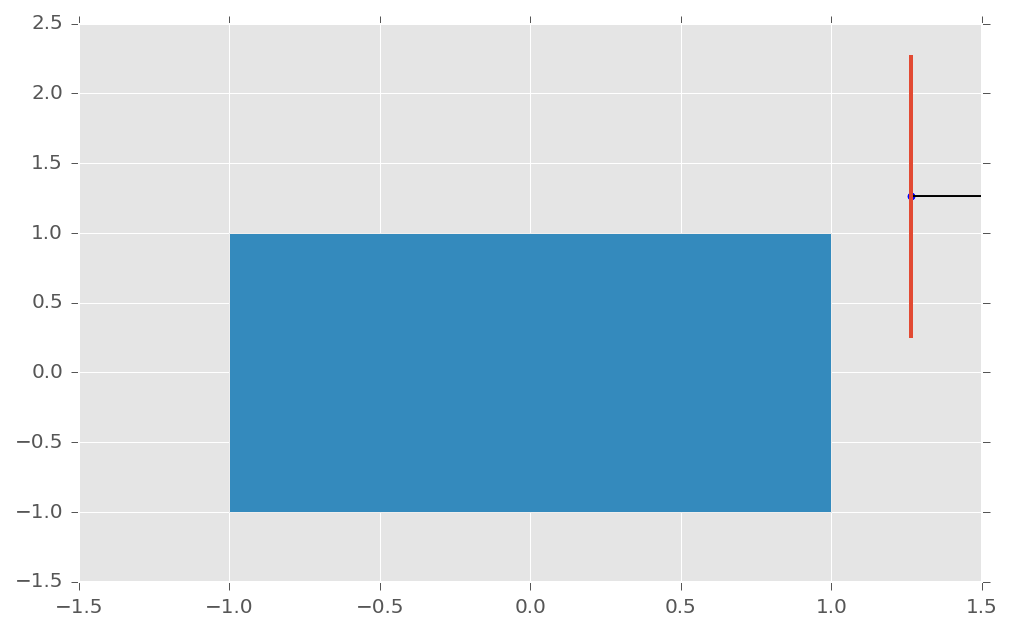

In [16]:
POINT = np.array([ 1.26403501, 1.26403501])
plot_poly(*SQUARE2D)
pl.scatter([POINT[0]], [POINT[1]])

res = contained(POINT, SQUARE2D)
if not (res is True):
    plot_hyperplane(res, POINT)

# Ellipsoid Method

In [17]:
def ellipsoid_iter(c, oracle, ball):
    n = len(c)
    x, R = ball
    A = R**2 * np.eye(n)
    
    while True:
        sep = oracle(x)
        yield x, A, sep
        a = c if sep is True else -sep
        x += 1. / (n+1) * A.dot(a) / np.sqrt(a.dot(A.dot(a)))
        A = n**2 / (n**2 - 1) * (A - 2. / (n+1) * A.dot(proj(a).dot(A)) / a.dot(A.dot(a)))

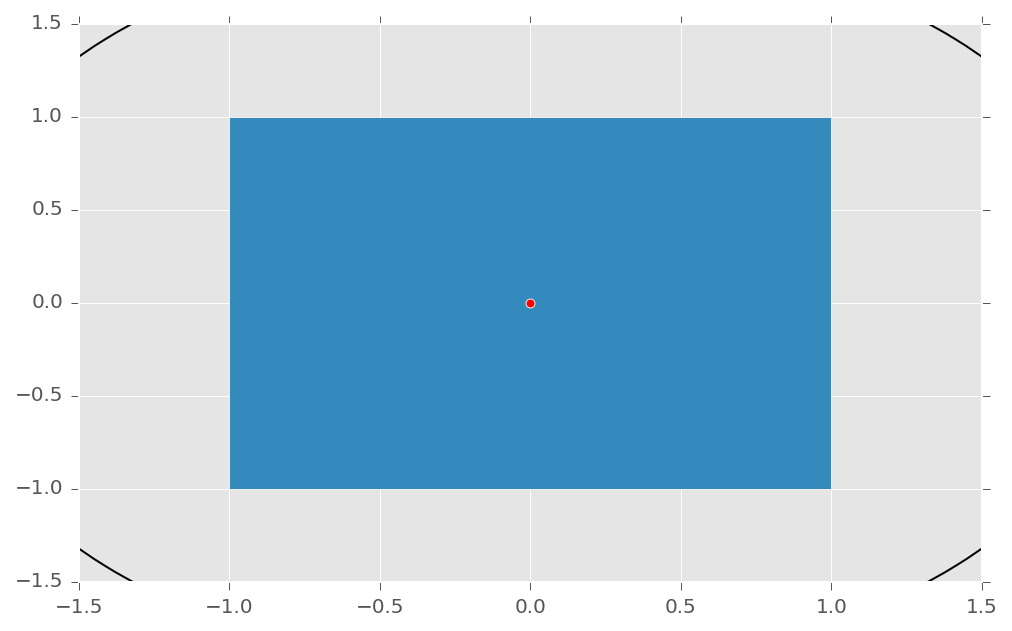

[ 0.  0.] 16.0


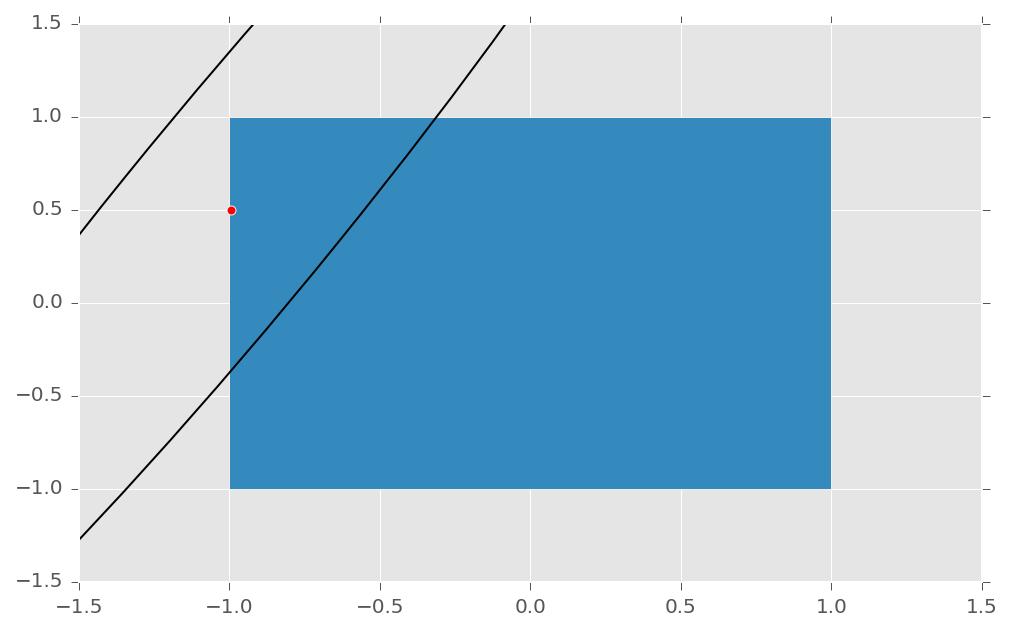

[-0.99380799  0.49690399] 5.61865569273


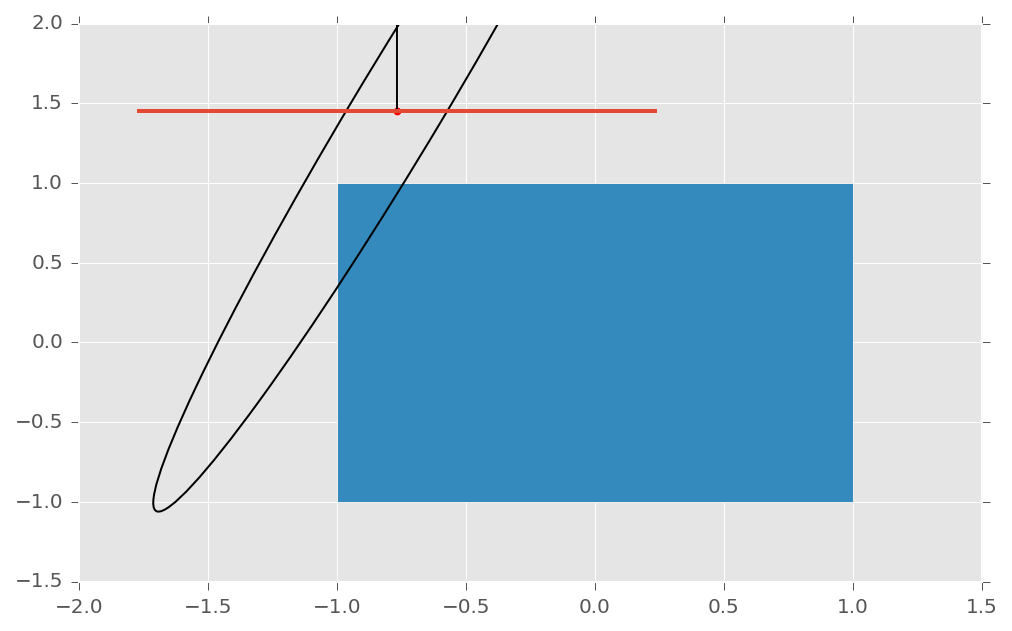

[-0.76697557  1.45444689] 1.97308073709


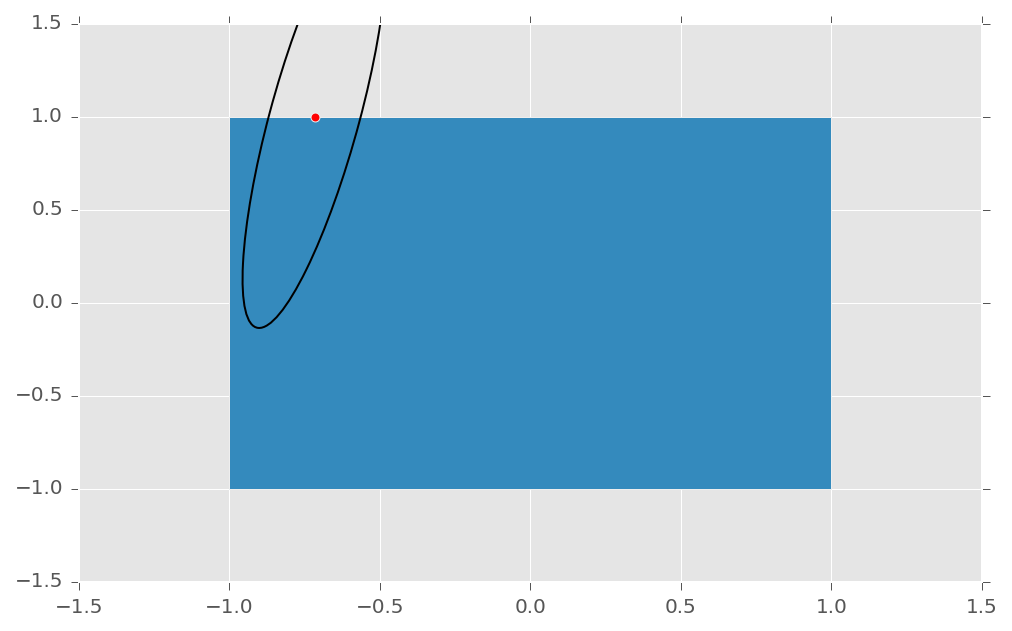

[-0.71708006  0.99618873] 0.692878832229


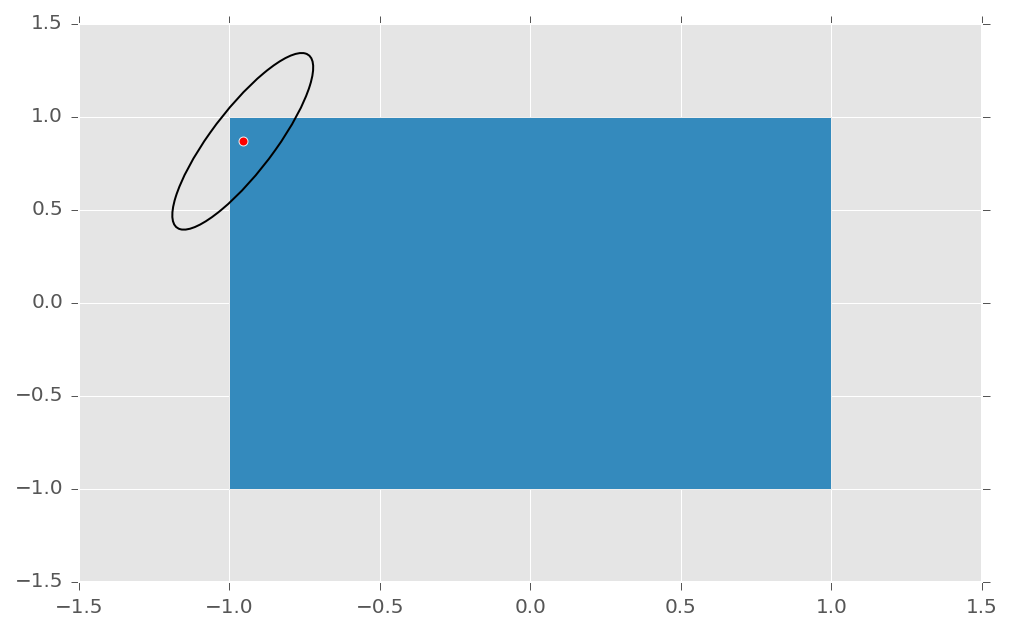

[-0.9555404   0.86702672] 0.243315474692


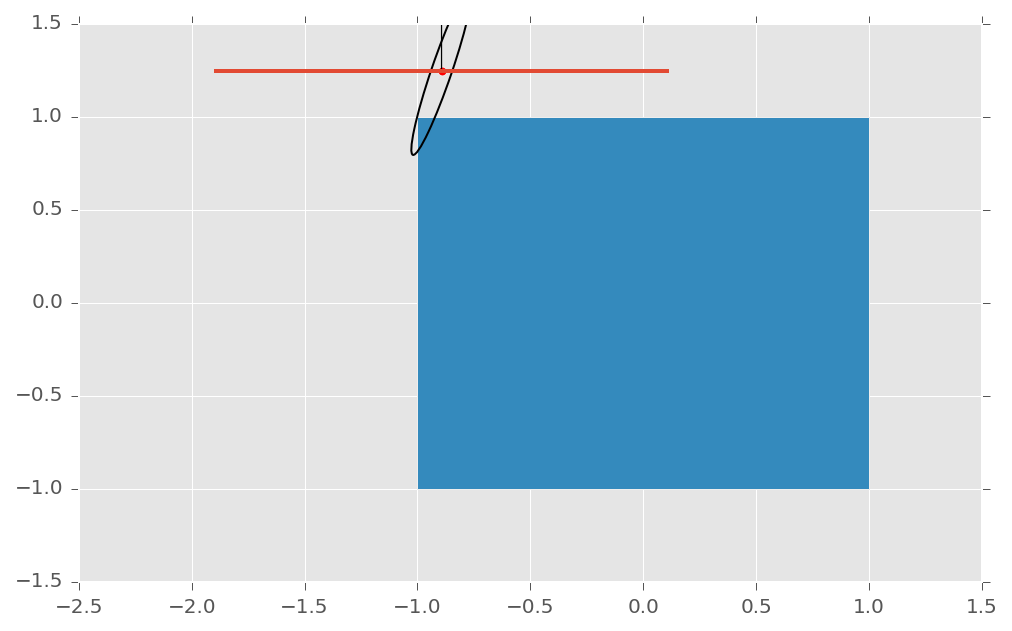

[-0.89334234  1.24467268] 0.0854441173131


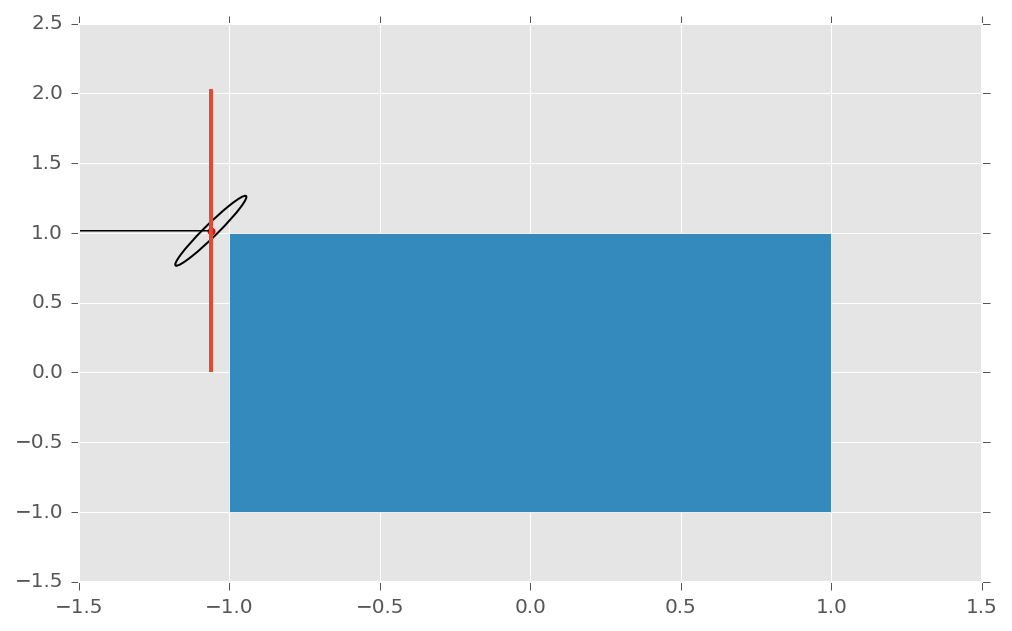

[-1.06161377  1.01498485] 0.0300050672595


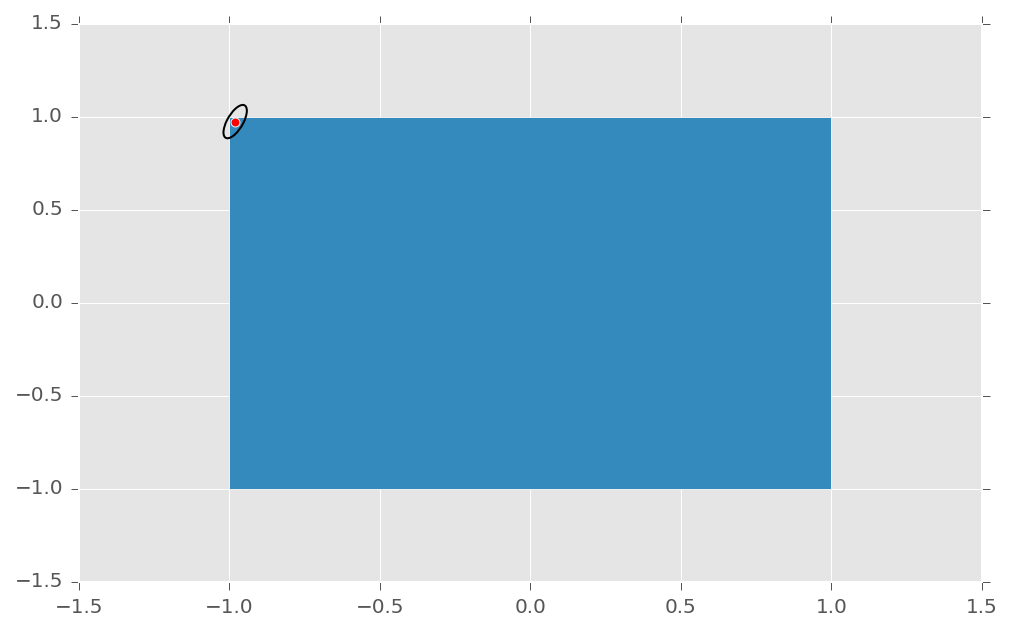

[-0.98075454  0.9731464 ] 0.010536758873


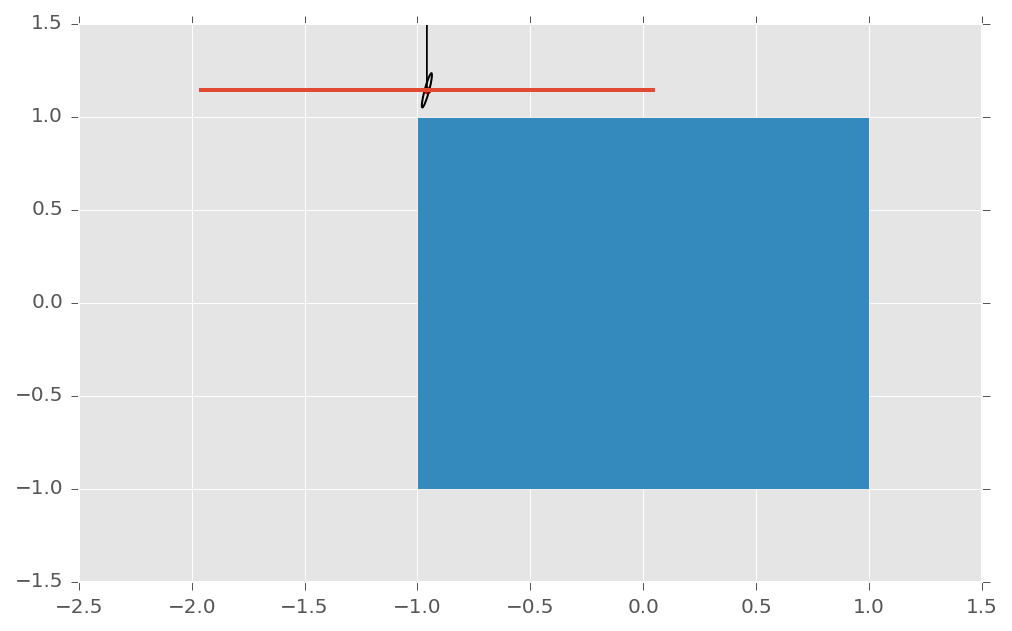

[-0.95825462  1.14123258] 0.00370015126405


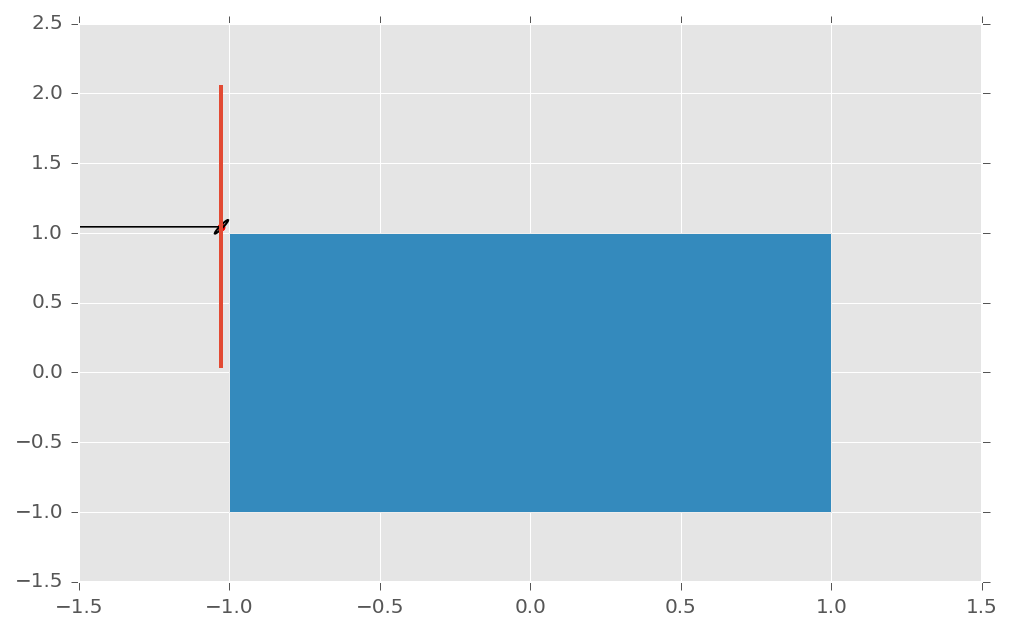

[-1.0262852   1.04326517] 0.00129936724773


In [18]:
SCORE = np.array([-2., 1.])
BALL = (np.array([0., 0.]), 2.)
solution = ellipsoid_iter(SCORE, lambda x: contained(x, SQUARE2D), BALL)

for x, A, c in it.islice(solution, 0, 20, 2):
    plot_poly(*SQUARE2D)
    pl.scatter([x[0]], [x[1]], c='r')
    plot_ellipse(x, A)

    if not (c is True):
        plot_hyperplane(c, x)
    pl.show()
    print(x, np.linalg.det(A))

In [ ]:
Ellipsis()